In [ ]:
'''
this script run the k-mean to fit in 6 clusters.
i) the normed sentiment arcs with 100 dimentiona movies is found in '../data/normed_sentiment_with_genome/'.
------
the progression to combine:
1) run the k-means and give diffrent name,colors of clusters.
2) split the movies by the cluaters and separately saved in the '../data/k_means_result/'
3) draw the emotional arcs of each movie and seperated them as clusters they belong.
4) used the t-Sne to transfer the 100-dimentionaal emotionals arc to 2-dimentinoal for visualizing on the plane.
------
'''

In [198]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
from collections import defaultdict
import csv
import pandas as pd
import numpy as np
import os


In [47]:
def load_normed_sentiment(path_to_load):
    file_names=list(set(os.listdir(path_to_load)))
    sentiment_matrix=[]
    index_filename_dict={}
    movie_name2_sentiment_index={}
    index=0
    for file_name in file_names:
        if file_name!='.DS_Store':
            sentiment=pd.read_csv(path_to_load+file_name).values
            sentiment=sentiment.ravel()
            sentiment_matrix.append(sentiment)
            index_filename_dict[index]=file_name
            movie_name2_sentiment_index[file_name[:-4]]=index
            index+=1
    return sentiment_matrix,index_filename_dict,movie_name2_sentiment_index

In [87]:
sentiment_matrix,index_filename_dict,movie_name2_sentiment_index=load_normed_sentiment('../data/normed_sentiment/')


In [93]:
def shape_clusters(n_clusters, random_state, sentiment_matrix):
    '''
    Input: Number of clusters, random state of model.
    Output: vector with number of each cluster, array with both sentiment changes and which cluster each movie belongs to, and (if ending is omitted) a separate column vector of each movie's ending sentiment change.
    '''
    model = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_numbers = model.fit_predict(sentiment_matrix)

    #Add the clusters as the last column of the data frame.
    X_and_clus = np.column_stack((sentiment_matrix, cluster_numbers))

    return cluster_numbers, X_and_clus

In [216]:
cluster_numbers, X_and_clus = shape_clusters(4, 483, sentiment_matrix)

In [64]:
def ClusterIndices_group(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

In [70]:
def K_means_for_normed_sentiment(sentiment_matrix,cluster_number):

    X=np.array(sentiment_matrix)
    kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(X)
    clustered_full_sentiment_maxtrix=[]
    cluster_index_list=[]
    for num in range(cluster_number):
        cluster_index=ClusterIndices_group(num,kmeans.labels_)
        cluster_index_list.append(cluster_index)
        cluster_sentiment_maxtrix= [sentiment_matrix[i] for i in cluster_index]
        clustered_full_sentiment_maxtrix.append(cluster_sentiment_maxtrix)
    return cluster_index_list,clustered_full_sentiment_maxtrix,kmeans.cluster_centers_

In [71]:
cluster_index_list,clustered_full_sentiment_maxtrix,kmeans_cluster_centers = K_means_for_normed_sentiment(sentiment_matrix,6)

In [80]:
def draw_clusters(clustered_full_sentiment_maxtrix,kmeans_cluster_centers):
    cluster_num=len(kmeans_cluster_centers)
    fig,ax=plt.subplots(cluster_num,figsize=(5,20))
    fig.tight_layout()
    for i in range(cluster_num):
        cluster_sentiment_matrix=clustered_full_sentiment_maxtrix[i]
        print 
        len(cluster_sentiment_matrix)
        for file_sentiment in cluster_sentiment_matrix:
                file_sentiment=np.asarray(file_sentiment).ravel()
                ax[i].plot(file_sentiment,color='lightgrey',linewidth=0.2)
        ax[i].plot(kmeans_cluster_centers[i],color='orangered')
        ax[i].set_xlabel('time')
        ax[i].set_ylabel('emotionality')
    if not os.path.exists('../data/k_means_result'):
        os.mkdir('../data/k_means_result')
    plt.savefig('../data/k_means_result/k_means_sentiment.png', dpi=300)
    plt.show()

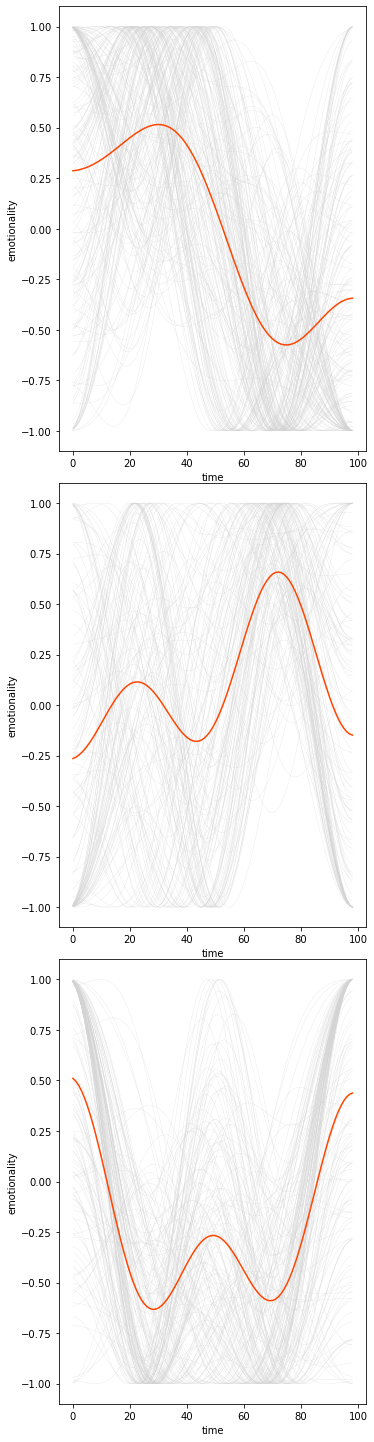

In [185]:
if __name__ == "__main__":
    path_to_load='../data/normed_sentiment/'
    cluster_num=3
    sentiment_matrix,index_filename_dict,movie_name2_sentiment_index=load_normed_sentiment(path_to_load)
    cluslter_index_list,clustered_full_sentiment_maxtrix,kmeans_cluster_centers=K_means_for_normed_sentiment(sentiment_matrix,cluster_num)
    draw_clusters(clustered_full_sentiment_maxtrix,kmeans_cluster_centers)

In [142]:
def get_script_filepaths(filepath):
    '''
    Input: Path into folder full of scripts.
    Output: List of filepaths to each script.
    '''
    paths = []
    for script in os.listdir(filepath):
        if not script.startswith('.') and os.path.isfile(os.path.join(filepath, script)):
            new_path = '../data/normed_sentiment/{}'.format(script)
        paths.append(new_path)
    paths = paths[1:]
    return paths

In [147]:
path = get_script_filepaths('../data/normed_sentiment')

In [162]:
def make_array(paths, number_movies):
    '''
    Inputs: paths = list of filepaths to movie scripts
    number_movies = how many of the movies to use (for quicker runtime, choose smaller number)
    window_divisor = We will divide the length of the movie by this to get a proportionally sized window for each movie.
    Output: X is an array with dimensions (number_movies, window_divisor) that gives the sentiment for each window in the movie.
    '''
    movie_list = paths[0:number_movies]
    
    movie_names = []
    
    for movie in movie_list:
        movie_names.append(movie)
        
    #Make it just the name of the movie instead of the whole filepath
    for i,value in enumerate(movie_names):
        movie_names[i] = 'Subtitles/' + value.replace(value, value[25:])

    movie_names = np.array(movie_names)

    return movie_names


In [164]:
movie_names = make_array(path, 483)

In [178]:
def add_features(X_and_clus, movie_names, meta=True, ending=None):
    '''
    Input: Array of movie sentiments and clusters, array of movie names.
    Output: A dataframe of these things in addition to other web-scraped movie metadata.
    '''
    cols = []
    for i,column in enumerate(X_and_clus.T):
        col_name = 'window_{}'.format(i)
        cols.append(col_name)

    cols[-1] = cols[-1].replace(cols[-1], 'predicted_cluster')

    df = pd.DataFrame(X_and_clus, columns=cols)
    df['Subtitles'] = movie_names
    return df

In [217]:
df = add_features(X_and_clus, movie_names, meta=False)

In [214]:
df

,window_0,window_1,window_2,window_3,window_4,window_5,window_6,window_7,window_8,window_9,...,window_91,window_92,window_93,window_94,window_95,window_96,window_97,window_98,predicted_cluster,Subtitles
0,0.986450,0.959537,0.919635,0.867298,0.803250,0.728379,0.643718,0.550436,0.449816,0.343239,...,-0.161304,-0.122315,-0.087347,-0.057092,-0.032145,-0.012995,-0.000017,0.006536,4.0,Subtitles/subtitles_tt10525672.txt
1,-0.664619,-0.671059,-0.680570,-0.692979,-0.708058,-0.725527,-0.745063,-0.766303,-0.788847,-0.812269,...,0.836437,0.875601,0.910073,0.939448,0.963377,0.981579,0.993835,1.000000,2.0,Subtitles/subtitles_tt9737326.txt
2,0.622889,0.632081,0.645614,0.663187,0.684405,0.708787,0.735775,0.764740,0.794996,0.825808,...,-0.072452,-0.095946,-0.117172,-0.135646,-0.150947,-0.162732,-0.170738,-0.174785,0.0,Subtitles/subtitles_tt1673434.txt
3,0.989395,0.968306,0.936973,0.895755,0.845119,0.785642,0.717993,0.642936,0.561311,0.474025,...,-0.522125,-0.509862,-0.498743,-0.489039,-0.480983,-0.474767,-0.470539,-0.468400,4.0,Subtitles/subtitles_tt11893274.txt
4,0.996533,0.989590,0.979149,0.965183,0.947657,0.926530,0.901762,0.873314,0.841151,0.805248,...,-0.412236,-0.465695,-0.512924,-0.553289,-0.586251,-0.611366,-0.628299,-0.636822,3.0,Subtitles/subtitles_tt11347146.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,-0.143699,-0.145410,-0.147961,-0.151337,-0.155516,-0.160471,-0.166175,-0.172593,-0.179692,-0.187436,...,0.812456,0.858018,0.897767,0.931387,0.958611,0.979222,0.993055,1.000000,2.0,Subtitles/subtitles_tt7975244.txt
478,-0.275522,-0.276270,-0.277368,-0.278783,-0.280479,-0.282407,-0.284515,-0.286746,-0.289041,-0.291338,...,0.775507,0.829784,0.877275,0.917543,0.950217,0.974992,0.991638,1.000000,2.0,Subtitles/subtitles_tt8310474.txt
479,-0.993731,-0.981282,-0.962831,-0.938643,-0.909063,-0.874512,-0.835482,-0.792527,-0.746255,-0.697318,...,0.917083,0.904480,0.892867,0.882604,0.874004,0.867324,0.862759,0.860443,3.0,Subtitles/subtitles_tt13655328.txt
480,0.386193,0.397262,0.413624,0.434995,0.461005,0.491198,0.525048,0.561958,0.601276,0.642305,...,-0.830866,-0.870973,-0.906487,-0.936899,-0.961771,-0.980747,-0.993551,-1.000000,0.0,Subtitles/subtitles_tt12299824.txt


In [218]:
df.to_csv('../data/clusters_4.csv',index=False)

In [208]:
report_df

,Sum of squared error
1,18422.872247
2,14437.873770
3,12115.258344
4,10385.503465
5,9059.539427
6,8085.750559
7,7384.337818
8,6809.106043
9,6315.465640
10,5920.673482


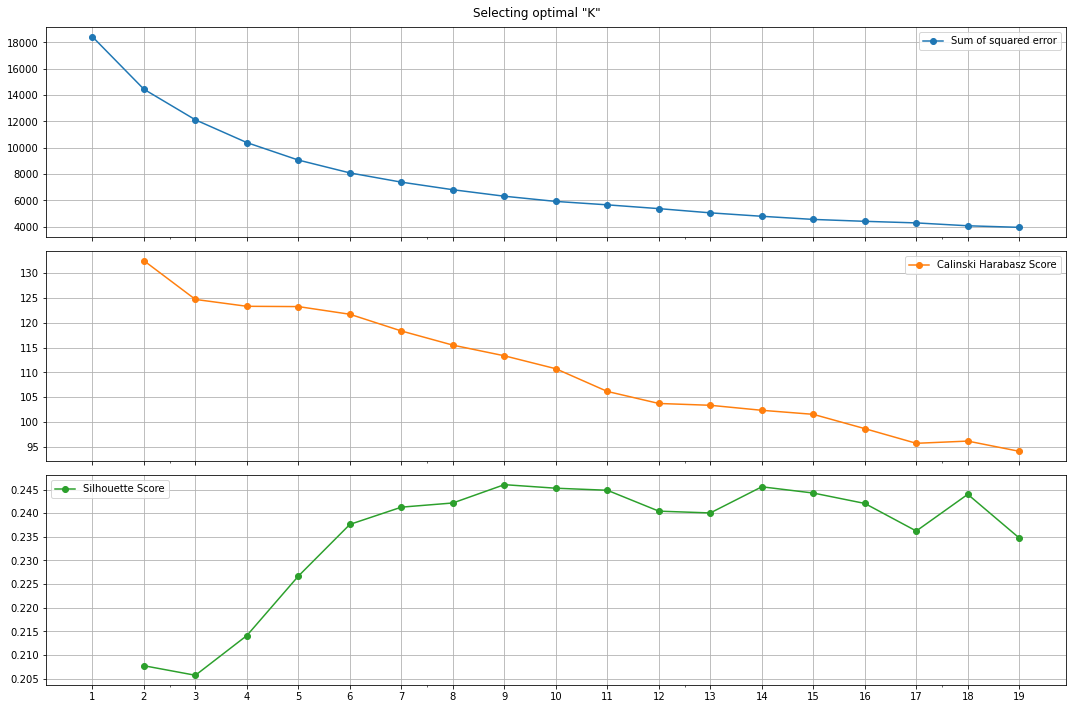

In [209]:
from sklearn.cluster import KMeans

search_range = range(1, 20)
report = {}
for k in search_range:
    temp_dict = {}
    kmeans = KMeans(init='k-means++',
                    algorithm='auto',
                    n_clusters=k,
                    max_iter=1000,
                    random_state=1,
                    verbose=0).fit(sentiment_matrix)
    inertia = kmeans.inertia_
    temp_dict['Sum of squared error'] = inertia
    try:
        cluster = kmeans.predict(sentiment_matrix)
        chs = calinski_harabasz_score(sentiment_matrix, cluster)
        ss = silhouette_score(sentiment_matrix, cluster)
        temp_dict['Calinski Harabasz Score'] = chs
        temp_dict['Silhouette Score'] = ss
        report[k] = temp_dict
    except:
        report[k] = temp_dict

report_df = pd.DataFrame(report).T
report_df.plot(figsize=(15, 10),
               xticks=search_range,
               grid=True,
               title=f'Selecting optimal "K"',
               subplots=True,
               marker='o',
               sharex=True)
plt.tight_layout()

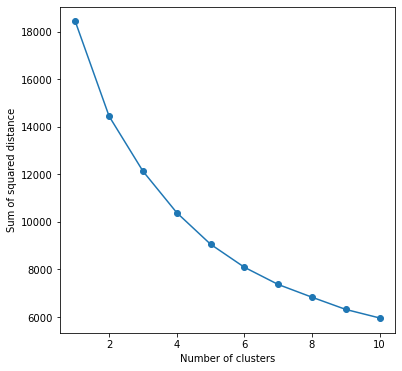

In [211]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 11))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(sentiment_matrix)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters')
plt.ylabel('Sum of squared distance');

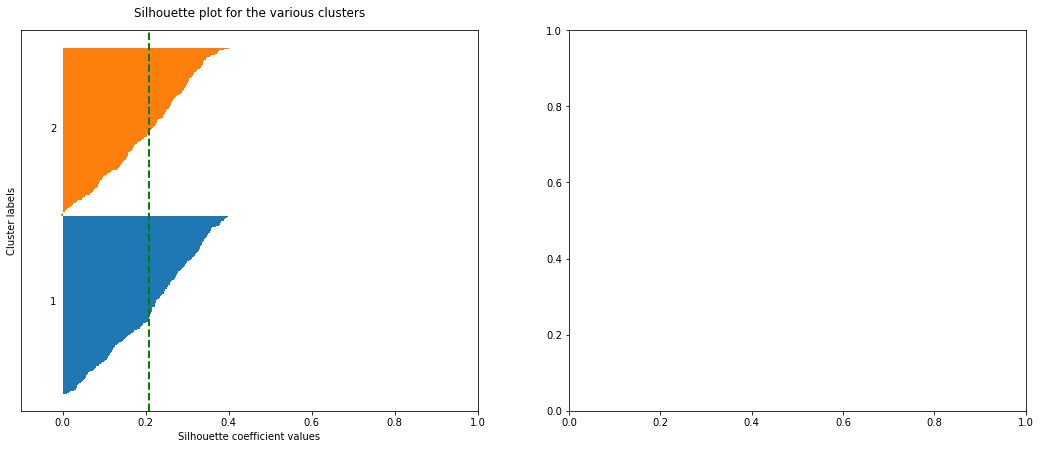

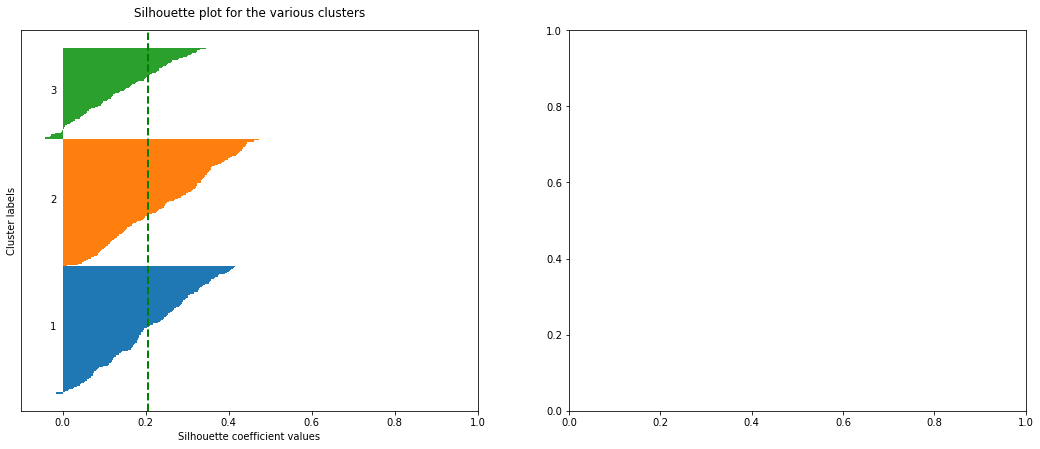

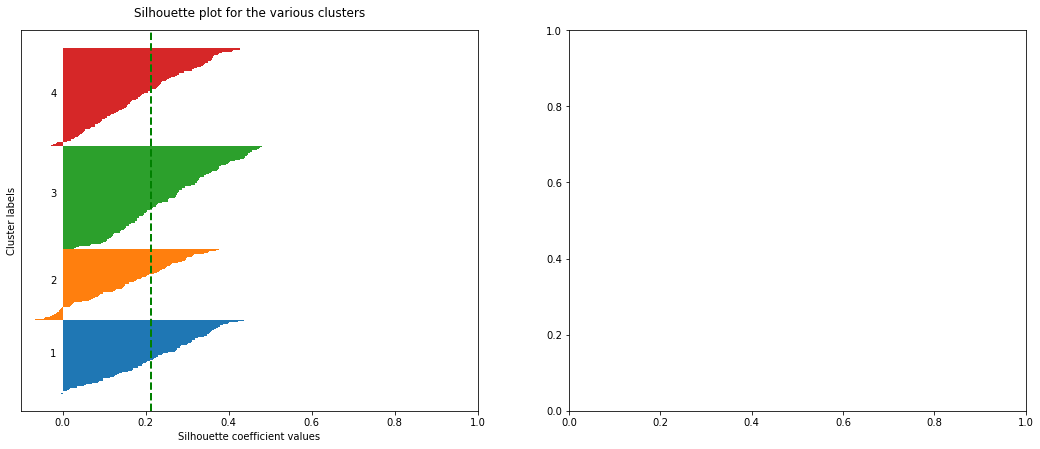

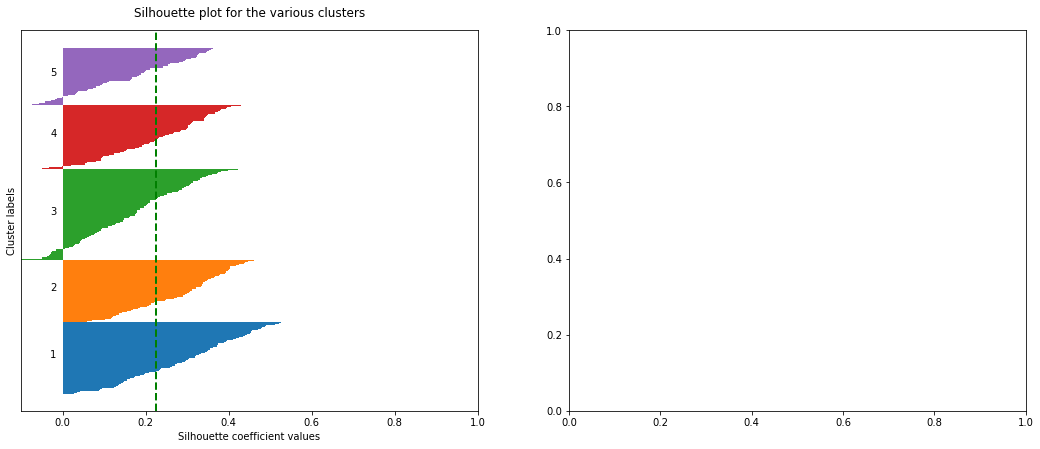

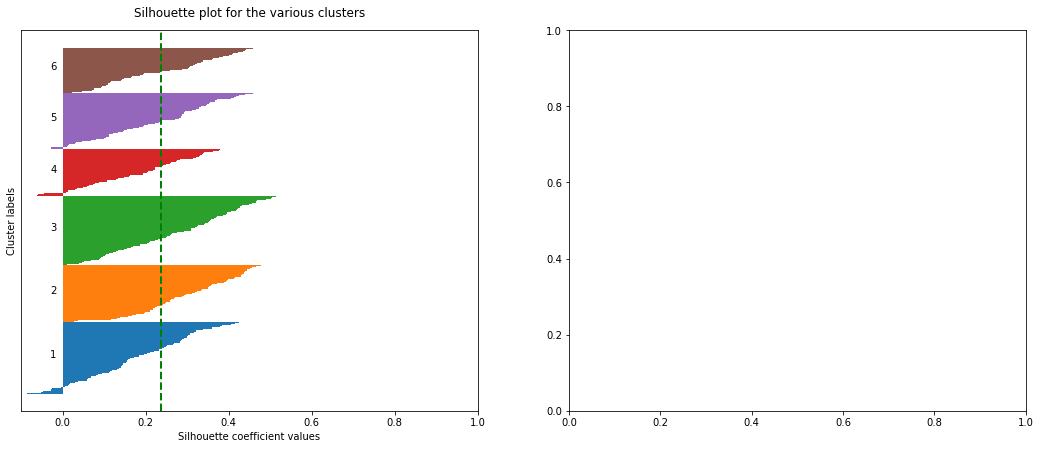

In [196]:
for i, k in enumerate([2,3,4,5,6]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(sentiment_matrix)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(sentiment_matrix, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);